In [1]:
from scipy import io
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
from quaternion import Quaternion
%matplotlib inline

data_num = 1
imu = io.loadmat("imu/imuRaw"+str(data_num)+".mat")
accel_raw = imu["vals"][0:3,:].astype(float)
gyro_raw = imu["vals"][3:6,:].astype(float)
ts = imu["ts"][0,:].astype(float)
T = len(ts)
# take dt as average of time differences
dt = np.mean(np.diff(ts))

C:\Users\Chandravaran K V\Anaconda3\envs\open3d\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
vicon = io.loadmat("vicon/viconRot"+str(data_num)+".mat")
vicon_rots = vicon["rots"].astype(float)
vicon_ts = vicon["ts"][0,:].astype(float)
vicon_T = len(vicon_ts)
vicon_dt = np.mean(np.diff(vicon_ts))

## imu data format

- accel: (3, T)
- gyro: (3, T)

In [3]:
def raw_to_physical_meas(raw, beta, alpha):
    return (raw - beta) * ((3300.0) / (1023.0 * alpha))

def preprocess_imu(accel, gyro):
    '''
    iron out quirks in the imu data
    
    1. negate x, y in accel
    2. move z gyro to last row
    '''
    accel_out = np.zeros_like(accel)
    # 1. negate x, y in accel
    accel_out[0,:] = np.negative(accel[0,:])
    accel_out[1,:] = np.negative(accel[1,:])
    accel_out[2,:] = accel[2,:]
    
    # 2. switch gyro axes
    gyro_out = np.zeros_like(gyro)
    gyro_out[2,:] = gyro[0,:]
    gyro_out[1,:] = gyro[2,:]
    gyro_out[0,:] = gyro[1,:]
    
    return accel_out, gyro_out

def vicon_to_imu_frame_orientation(vicon_rots):
    # vicon rots are rotation matrices
    # create heading vectors from rotation matrices, and plot the x, y, z components
    heading = np.array([0, 0, 9.81])
    vicon_orientations = np.zeros((3, T))
    vicon_orientations = np.matmul(vicon_rots.T, heading).T
    
    return vicon_orientations

In [4]:
accel, gyro = preprocess_imu(accel_raw, gyro_raw)
vicon_orientations = vicon_to_imu_frame_orientation(vicon_rots)

accel_alphas = np.array([[34.5676],
        [34.2750],
        [34.4393]])
accel_betas = np.array([[-511.1268],
        [-500.4646],
        [500.8905]])

gyro_alphas = np.array([250,250,250]).reshape(3,1)
gyro_betas = np.array([374.5,375.2,373.1]).reshape(3,1)

accel_calib = raw_to_physical_meas(accel, accel_betas, accel_alphas)
gyro_calib = raw_to_physical_meas(gyro, gyro_betas, gyro_alphas)



[-511. -501.  605.]
[ 0.11  -0.016  9.809]


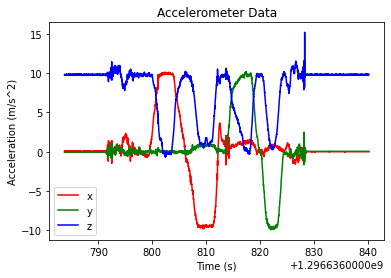

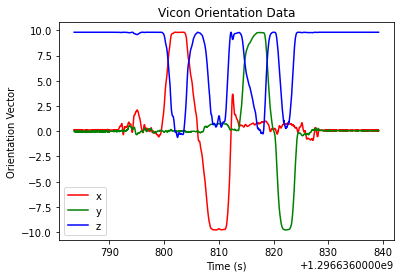

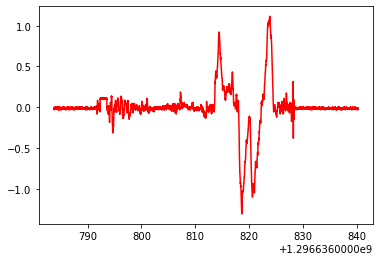

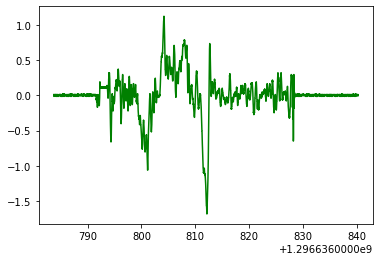

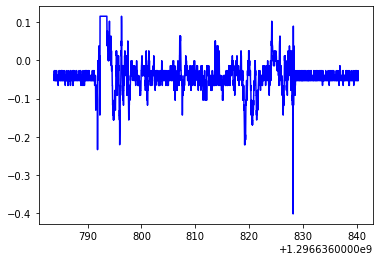

In [5]:

# plot out accel data
plt.figure()
plt.plot(ts, accel_calib[0,:], label="x", color="red")
plt.plot(ts, accel_calib[1,:], label="y", color="green")
plt.plot(ts, accel_calib[2,:], label="z", color="blue")
plt.legend()
plt.title("Accelerometer Data")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")

# plot out vicon orientation data
plt.figure()
plt.plot(vicon_ts, vicon_orientations[0,:], label="x", color="red")
plt.plot(vicon_ts, vicon_orientations[1,:], label="y", color="green")
plt.plot(vicon_ts, vicon_orientations[2,:], label="z", color="blue")
plt.legend()
plt.title("Vicon Orientation Data")
plt.xlabel("Time (s)")
plt.ylabel("Orientation Vector")

# plot out gyro data, x, y, z in separate plots
plt.figure()
plt.plot(ts, gyro_calib[0,:], label="x", color="red")
plt.figure()
plt.plot(ts, gyro_calib[1,:], label="y", color="green")
plt.figure()
plt.plot(ts, gyro_calib[2,:], label="z", color="blue")

print(accel[:,0])
print(vicon_orientations[:,0])

Text(0, 0.5, 'Omega (rad/s)')

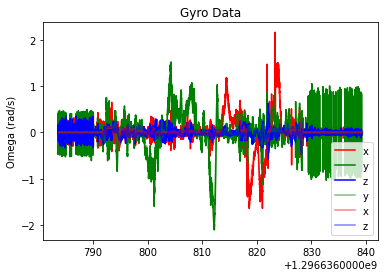

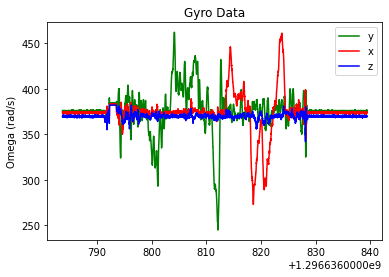

In [6]:
vicon_quats = []
for i in range(vicon_T):
    vicon_quat = Quaternion()
    vicon_quat.from_rotm(vicon_rots[:,:,i])
    vicon_quats.append(vicon_quat)

vicon_omegas = np.zeros((3, vicon_T))
for i in range(1, vicon_T):
    vicon_quat = vicon_quats[i-1].inv() * vicon_quats[i]
    vicon_omegas[:,i] = vicon_quat.axis_angle(dt=vicon_dt)
    
#plot out vicon omega data
plt.figure()
plt.plot(vicon_ts, vicon_omegas[0,:], label="x", color="red")
plt.plot(vicon_ts, vicon_omegas[1,:], label="y", color="green")
plt.plot(vicon_ts, vicon_omegas[2,:], label="z", color="blue")
plt.legend()
plt.title("Vicon Omega Data")
plt.ylabel("Omega (rad/s)")
# plot out gyro data

plt.plot(ts[:vicon_T], gyro_calib[1,:vicon_T], label="y", color="green", alpha=0.5)
plt.plot(ts[:vicon_T], gyro_calib[0,:vicon_T], label="x", color="red", alpha=0.5)
plt.plot(ts[:vicon_T], gyro_calib[2,:vicon_T], label="z", color="blue", alpha=0.5)
plt.legend()
plt.title("Gyro Data")
plt.ylabel("Omega (rad/s)")

plt.figure()
plt.plot(ts[:vicon_T], gyro[1,:vicon_T], label="y", color="green")
plt.plot(ts[:vicon_T], gyro[0,:vicon_T], label="x", color="red")
plt.plot(ts[:vicon_T], gyro[2,:vicon_T], label="z", color="blue")
plt.legend()
plt.title("Gyro Data")
plt.ylabel("Omega (rad/s)")


In [10]:
# nonlinear least-squares calibration routine

import torch
from torch.autograd import Variable

def calibrate(x, y, alpha_ref, beta_ref, learning_rate=1e-4, epochs=4000, r=1):

    dtype = torch.FloatTensor

    x = torch.from_numpy(x).type(dtype)
    y = torch.from_numpy(y).type(dtype)

    # clip x, y to shortest one
    x = x[:,:min(x.shape[1], y.shape[1])]
    y = y[:,:min(x.shape[1], y.shape[1])]

    alpha_ref = torch.from_numpy(alpha_ref)
    beta_ref = torch.from_numpy(beta_ref)

    alpha = Variable(alpha_ref.type(dtype), requires_grad=True)
    beta = Variable(beta_ref.type(dtype), requires_grad=True)

    # calibrate alpha, beta using backprop
    
    for t in range(epochs):
        
        # forward pass
        y_pred = (x - beta) * (3300.0) / (1023.0 * alpha)
        
        # compute loss
        loss = (y_pred - y).pow(2).sum() + r * ((alpha - alpha_ref).pow(2).sum() + (beta - beta_ref).pow(2).sum())
        
        # backprop
        loss.backward()
        
        # update parameters
        alpha.data -= learning_rate * alpha.grad.data
        beta.data -= learning_rate * beta.grad.data
        
        # zero gradients
        alpha.grad.data.zero_()
        beta.grad.data.zero_()
            
        if t % 500 == 0:
            print("t: ", t, " loss: ", loss.data)
        
    return alpha, beta

beta_ref = np.array([-500,-500,500]).reshape(3,1)
alpha_ref = np.array([25,25,25]).reshape(3,1)
alpha_accel, beta_accel = calibrate(accel, vicon_orientations, alpha_ref, beta_ref)
print("alpha accel: ", alpha_accel.data)
print("beta accel: ", beta_accel.data) 

'''
beta_ref = np.array([375,375,375]).reshape(3,1)
alpha_ref = np.array([250,250,250]).reshape(3,1)
alpha_gyro, beta_gyro = calibrate(gyro, vicon_omegas, alpha_ref, beta_ref, r=1)
print("alpha gyro: ", alpha_gyro.data)
print("beta gyro: ", beta_gyro.data)'''

t:  0  loss:  tensor(95803.4609)
t:  500  loss:  tensor(5604.3896)
t:  1000  loss:  tensor(5599.7749)
t:  1500  loss:  tensor(5598.9653)
t:  2000  loss:  tensor(5598.8110)
t:  2500  loss:  tensor(5598.7812)
t:  3000  loss:  tensor(5598.7749)
t:  3500  loss:  tensor(5598.7754)
alpha accel:  tensor([[34.5676],
        [34.2750],
        [34.4407]])
beta accel:  tensor([[-511.1268],
        [-500.4646],
        [ 500.8867]])


'\nbeta_ref = np.array([375,375,375]).reshape(3,1)\nalpha_ref = np.array([250,250,250]).reshape(3,1)\nalpha_gyro, beta_gyro = calibrate(gyro, vicon_omegas, alpha_ref, beta_ref, r=1)\nprint("alpha gyro: ", alpha_gyro.data)\nprint("beta gyro: ", beta_gyro.data)'

In [7]:
a = np.array([1,2,4])
b = np.array([5,6,7])
c = np.array([a,b])


a1 = np.array([1,2,4])
b1 = np.array([5,6,7])
c1 = np.array([a1,b1])

avg = np.mean(np.array([c,c1]), axis=0)
avg

array([[1., 2., 4.],
       [5., 6., 7.]])